In [1]:
# add our custom modules to the python import path
import sys
import os
import numpy as np
from qick import *
sys.path.append(os.getcwd() + '/../../Client_modules/')

import mResSweep
from socProxy import makeProxy
import h5py
from PythonDrivers.control_atten import setatten
%matplotlib inline
import matplotlib.pyplot as plt

# Python 3.7
# os.environ['PATH'] = os.getcwd() + '\\PythonDrivers' + os.pathsep + os.environ['PATH']
# Python 3.8 and newer
os.add_dll_directory(os.getcwd() + '/../../Client_modules/PythonDrivers')

Could not import QickSoc: No module named 'pynq'


<AddedDllDirectory('C:\\Users\\my\\Documents\\GitHub\\ZCU216_Russell\\res_dev\\notebooks\\2022-10-16 ZCU216 loopback/../../Client_modules/PythonDrivers')>

In [2]:
# create proxy to ZCU216 board
soc, soccfg = makeProxy('192.168.1.108')
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@192.168.1.108:8888
myqick PYRO:obj_aa2025c83beb4450998b09a13eeae25d@192.168.1.108:45473

QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v4 - tProc output 1, switch ch 0, maxlen 65536
		DAC tile 2, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	1:	axis_signal_gen_v4 - tProc output 2, switch ch 1, maxlen 65536
		DAC tile 2, ch 1, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	2:	axis_signal_gen_v4 - tProc output 3, switch ch 2, maxlen 65536
		DAC tile 2, ch 2, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	3:	axis_signal_gen_v4 - tProc output 4, switch ch 3, maxlen 65536
		DAC tile 2, ch 3, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	4:	axis_signal_gen_v4 - tProc output 5, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=430.080 MHz, fs=6881.280 MHz
	5:	axis_signal_gen_v4 - tProc output 6, switch ch 5, maxlen 65536
	

# define the program

In [29]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        print(self.cfg)

        # set the nyquist zone
        for i in cfg['res_ch']:
            self.declare_gen(ch=i, nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for i, ch in enumerate(cfg["ro_chs"]):
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freqs"][i], 
                                 gen_ch=cfg["res_ch"][i])

            # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
            freq = self.freq2reg(cfg["pulse_freqs"][i],gen_ch=cfg["res_ch"][i], 
                                 ro_ch=ch)
            phase = self.deg2reg(cfg["res_phases"][i], 
                                 gen_ch=cfg["res_ch"][i])
            gain = cfg["pulse_gains"][i]
#             self.default_pulse_registers(ch=cfg['res_ch'][i], freq=freq, phase=phase, 
#                                          gain=gain, mode='periodic', stdysel='last')
            self.default_pulse_registers(ch=cfg['res_ch'][i], freq=freq, phase=phase, 
                                         gain=gain)

            style=self.cfg["pulse_style"]

            if style in ["flat_top","arb"]:
                sigma = cfg["sigma"]
                self.add_gauss(ch=cfg["res_ch"][i], name="measure", sigma=sigma, length=sigma*5)

            if style == "const":
                self.set_pulse_registers(ch=cfg["res_ch"][i], style=style, 
                                         length=cfg["length"])
            elif style == "flat_top":
                # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
                self.set_pulse_registers(ch=cfg["res_ch"][i], style=style, waveform="measure", length=cfg["length"])
            elif style == "arb":
                self.set_pulse_registers(ch=cfg["res_ch"][i], style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
        for i, res_ch in enumerate(self.cfg['res_ch']):
            self.pulse(ch=self.cfg["res_ch"][i])
            self.sync_all()
        
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
#         for i, res_ch in enumerate(self.cfg['res_ch']):
#             self.measure(pulse_ch=res_ch, 
#                      adcs=[self.cfg['ro_chs'][i]],
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"],
#                      wait=True,
#                      syncdelay=self.us2cycles(self.cfg["relax_delay"]))

        for i, res_ch in enumerate(self.cfg['res_ch']):
            self.trigger(adcs=[self.cfg['ro_chs'][i]], pins=[0],
                            adc_trig_offset=self.cfg['adc_trig_offset'])  # trigger the adc acquisition
        
        # equivalent to the following:
#         self.trigger(adcs=self.ro_chs,
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"])
#         self.pulse(ch=self.cfg["res_ch"])
#         self.wait_all()
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

# run a single point, decimated

In [32]:
config={"res_ch":[0,2], # --Fixed
        "ro_chs":[0,1], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phases":[0,0], # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":30, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gains":[35000, 30000], # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units
        
        "pulse_freqs": [1958, 2261], # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)

{'res_ch': [0, 2], 'ro_chs': [0, 1], 'reps': 1, 'relax_delay': 1.0, 'res_phases': [0, 0], 'pulse_style': 'const', 'length': 30, 'readout_length': 100, 'pulse_gains': [35000, 30000], 'pulse_freqs': [1958, 2261], 'adc_trig_offset': 100, 'soft_avgs': 100}


  0%|          | 0/100 [00:00<?, ?it/s]

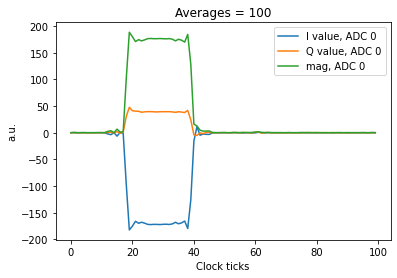

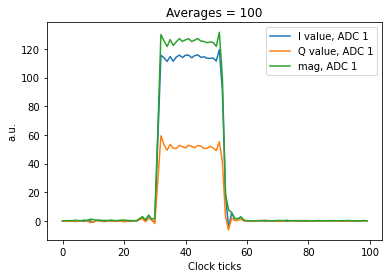

In [33]:
# Plot results.
for ii, iq in enumerate(iq_list):
    plt.figure(ii)
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
    plt.ylabel("a.u.")
    plt.xlabel("Clock ticks")
    plt.title("Averages = " + str(config["soft_avgs"]))
    plt.legend()

# run single point

In [ ]:
config={"res_ch":[0,2], # --Fixed
        "ro_chs":[0,1], # --Fixed
        "reps":20, # --Fixed
        "relax_delay":1.0, # --us
        "res_phases":[0,0], # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":2000, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gains":[3000, 3000], # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freqs": [1958.6099999999997, 2261.8864999999996], # [MHz]
#         "pulse_freqs": [2000], # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

       }
###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list = prog.acquire(soc, load_pulses=True, progress=True, debug=False)

for ii, iq in enumerate(iq_list):
    print(iq[0][0])
    print('Freq {0}, I = {1:0.2f}'.format(ii, iq[0][0]))
    print('Freq {0}, Q = {1:0.2f}'.format(ii, iq[1][0]))
    print('Freq {0}, phase = {1:0.2f}'.format(ii, np.arctan2(iq[1][0],iq[0][0])))
    print('')


# run two points

In [ ]:
config={"res_ch":[2], # --Fixed
        "ro_chs":[1], # --Fixed
        "reps":5, # --Fixed
        "relax_delay":1.0, # --us
        "res_phases":[0,0], # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":2000, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gains":[3000, 3000], # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freqs": [2000, 2100], # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 200, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

       }

###################
# Try it yourself !
###################

prog =LoopbackProgram(soccfg, config)
iq_list1 = prog.acquire(soc, load_pulses=True, progress=True, debug=False)
print(np.shape(iq_list1))

config['pulse_freqs'] = [1999, 2099]

prog =LoopbackProgram(soccfg, config)
iq_list2 = prog.acquire(soc, load_pulses=True, progress=True, debug=False)

config['pulse_freqs'] = [2000, 2100]

prog =LoopbackProgram(soccfg, config)
iq_list3 = prog.acquire(soc, load_pulses=True, progress=True, debug=False)

for ii, iq in enumerate(iq_list1):
#     print('Freq {0}, I = {1:0.2f}'.format(ii, iq[0][0]))
#     print('Freq {0}, Q = {1:0.2f}'.format(ii, iq[1][0]))
    print('Freq {0}, phase = {1:0.2f}'.format(ii, np.arctan2(iq[1][0],iq[0][0])))
    print('Freq {0}, mag = {1:0.2f}'.format(ii, np.abs(iq[1][0]+1j*iq[0][0])))
    print('')
    
for ii, iq in enumerate(iq_list2):
#     print('Freq {0}, I = {1:0.2f}'.format(ii, iq[0][0]))
#     print('Freq {0}, Q = {1:0.2f}'.format(ii, iq[1][0]))
    print('Freq {0}, phase = {1:0.2f}'.format(ii, np.arctan2(iq[1][0],iq[0][0])))
    print('Freq {0}, mag = {1:0.2f}'.format(ii, np.abs(iq[1][0]+1j*iq[0][0])))
    print('')
    
for ii, iq in enumerate(iq_list3):
#     print('Freq {0}, I = {1:0.2f}'.format(ii, iq[0][0]))
#     print('Freq {0}, Q = {1:0.2f}'.format(ii, iq[1][0]))
    print('Freq {0}, phase = {1:0.2f}'.format(ii, np.arctan2(iq[1][0],iq[0][0])))
    print('Freq {0}, mag = {1:0.2f}'.format(ii, np.abs(iq[1][0]+1j*iq[0][0])))
    print('')
